https://www.sciencedirect.com/science/article/pii/S2211812814005318

In [263]:
# import dependencies
%matplotlib inline
# import keras
from keras.models import Sequential
from keras.activations import *
from keras.layers import *
from keras.losses import *
from keras.optimizers import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import talos as ta
import warnings
warnings.filterwarnings("ignore")

# suppres NumPy arrays scientific notation and round decimals to three places
np.set_printoptions(suppress=True)
np.printoptions(precision=3, suppress=True)

#libraries = [np,
#             pd,
#             sklearn,
#             keras,
#            ta]
#for library in libraries:
#    print(library, ' ', library.__version__)


requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

In [264]:
# import training data
train_data = pd.read_csv('Training_Features_and_Labels.txt', delim_whitespace=True, encoding='ISO-8859-1')
train_data.drop(columns=['Sr._No.'], inplace=True)
# import validation data
test_data = pd.read_csv('Test_Features_and_Labels.txt', delim_whitespace=True, encoding='ISO-8859-1')
test_data.drop(columns=['Sr._No.'], inplace=True)
# segregate a single row for validation
validation_data = test_data.loc[0]
test_data = test_data.iloc[1:]

In [265]:
validation_data

Spindle_speed(rpm)    1100.00
Feed_rate(mm/rev)        0.05
Depth_of_cut(mm)         0.40
MRR(mm3/min)          1106.51
Ra(µm)                   0.21
Name: 0, dtype: float64

In [266]:
test_data

,Spindle_speed(rpm),Feed_rate(mm/rev),Depth_of_cut(mm),MRR(mm3/min),Ra(µm)
1,1100,0.05,0.69,2020.44,0.29
2,1095,0.15,1.20,6054.12,1.87
3,1097,0.13,1.14,5329.21,1.54
4,1094,0.12,1.15,5197.29,1.45


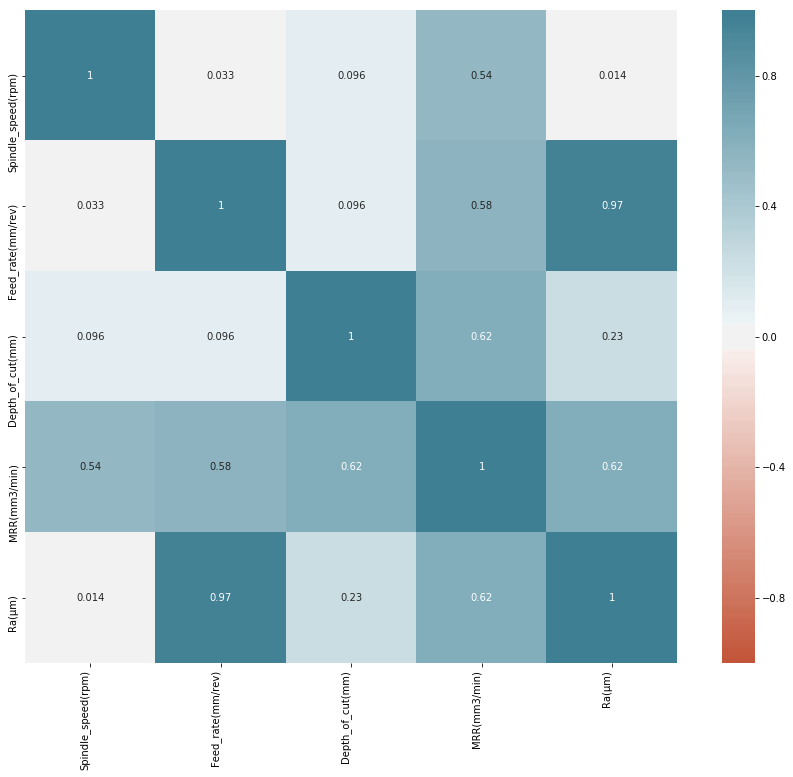

In [267]:
# a look at the overall correlation between training and testing data
df = pd.concat([train_data, test_data], axis=0, ignore_index=False)
heat_data = df
plt.figure(figsize=(16, 12))
corr = heat_data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);
plt.savefig('heatmap')

In [268]:
# create NumPy arrays of training features and labels
train_features = train_data[['MRR(mm3/min)', 'Ra(µm)']].values
train_labels = train_data[['Spindle_speed(rpm)', 'Feed_rate(mm/rev)', 'Depth_of_cut(mm)']].values
print('Training Features:\n\n', train_features)
print('\nTraining Labels:\n\n', train_labels) 

Training Features:

 [[ 306.67    0.36]
 [ 609.76    0.47]
 [ 909.28    0.52]
 [ 582.94    0.8 ]
 [1158.73    0.9 ]
 [1727.36    1.1 ]
 [ 943.34    1.63]
 [1875.96    1.76]
 [2797.84    2.17]
 [ 793.04    0.38]
 [1577.02    0.48]
 [2351.92    0.54]
 [1555.25    0.81]
 [3092.37    0.82]
 [4611.35    0.97]
 [2196.85    1.92]
 [4366.5     1.91]
 [6508.93    2.03]
 [ 875.13    0.29]
 [1735.95    0.37]
 [2582.46    0.38]
 [1745.24    0.82]
 [3461.88    0.79]
 [5149.9     1.11]
 [2549.2     1.75]
 [5055.49    1.89]
 [7518.86    1.82]]

Training Labels:

 [[ 280.        0.0508    0.4   ]
 [ 280.        0.0508    0.8   ]
 [ 280.        0.0508    1.2   ]
 [ 280.        0.1016    0.4   ]
 [ 280.        0.1016    0.8   ]
 [ 280.        0.1016    1.2   ]
 [ 280.        0.1524    0.4   ]
 [ 280.        0.1524    0.8   ]
 [ 280.        0.1524    1.2   ]
 [ 710.        0.0508    0.4   ]
 [ 710.        0.0508    0.8   ]
 [ 710.        0.0508    1.2   ]
 [ 710.        0.1016    0.4   ]
 [ 710.        0

In [269]:
# create NumPy arrays of validation features and labels
test_features = test_data[['MRR(mm3/min)', 'Ra(µm)']].values
test_labels = test_data[['Spindle_speed(rpm)', 'Feed_rate(mm/rev)', 'Depth_of_cut(mm)']].values
print('Testing Features:\n\n', test_features)
print('\nTesting Labels:\n\n', test_labels)

Testing Features:

 [[2020.44    0.29]
 [6054.12    1.87]
 [5329.21    1.54]
 [5197.29    1.45]]

Testing Labels:

 [[1100.      0.05    0.69]
 [1095.      0.15    1.2 ]
 [1097.      0.13    1.14]
 [1094.      0.12    1.15]]


In [270]:
# create NumPy array for validation data
validation_features = validation_data[['MRR(mm3/min)', 'Ra(µm)']].values
validation_labels = validation_data[['Spindle_speed(rpm)', 'Feed_rate(mm/rev)', 'Depth_of_cut(mm)']].values

# reshape the validation data because it's only one row
validation_features = validation_features.reshape(1, -1)
validation_labels = validation_labels.reshape(1, -1)

print('Validation Features:\n\n', validation_features)
print('\nValidation Labels:\n\n', validation_labels)

Validation Features:

 [[1106.51    0.21]]

Validation Labels:

 [[1100.      0.05    0.4 ]]


In [271]:
# Transforms features by scaling each feature to a given range, -1 and 1 in this case
MinMax_scaler = MinMaxScaler(feature_range=(-1, 1))
train_features_MinMax = MinMax_scaler.fit_transform(train_features)
train_labels_MinMax = MinMax_scaler.fit_transform(train_labels)
test_features_MinMax = MinMax_scaler.fit_transform(test_features)
test_labels_MinMax = MinMax_scaler.fit_transform(test_labels)
validation_features_MinMax = MinMax_scaler.fit_transform(validation_features)
validation_labels_MinMax = MinMax_scaler.fit_transform(validation_labels)

#MinMax_scaler.inverse_transform(validation_labels_MinMax)

In [272]:
test_data

,Spindle_speed(rpm),Feed_rate(mm/rev),Depth_of_cut(mm),MRR(mm3/min),Ra(µm)
1,1100,0.05,0.69,2020.44,0.29
2,1095,0.15,1.20,6054.12,1.87
3,1097,0.13,1.14,5329.21,1.54
4,1094,0.12,1.15,5197.29,1.45


In [273]:
test_labels

array([[1100.  ,    0.05,    0.69],
       [1095.  ,    0.15,    1.2 ],
       [1097.  ,    0.13,    1.14],
       [1094.  ,    0.12,    1.15]])

In [274]:
test_labels_MinMax

array([[ 1.        , -1.        , -1.        ],
       [-0.66666667,  1.        ,  1.        ],
       [ 0.        ,  0.6       ,  0.76470588],
       [-1.        ,  0.4       ,  0.80392157]])

In [275]:
MinMax_scaler.inverse_transform(test_labels_MinMax)

array([[1101.        ,    0.05      ,    0.4       ],
       [1100.16666667,    1.05      ,    1.4       ],
       [1100.5       ,    0.85      ,    1.28235294],
       [1100.        ,    0.75      ,    1.30196078]])

In [276]:
# Standardize features by removing the mean and scaling to unit variance
Standard_scaler = StandardScaler()
train_features_Standard = Standard_scaler.fit_transform(train_features)
train_labels_Standard = Standard_scaler.fit_transform(train_labels)
test_features_Standard = Standard_scaler.fit_transform(test_features)
test_labels_Standard = Standard_scaler.fit_transform(test_labels)
validation_features_Standard = Standard_scaler.fit_transform(validation_features)
validation_labels_Standard = Standard_scaler.fit_transform(validation_labels)

# Standard_scaler.inverse_transform(train_features_Standard)

In [277]:
p = {
    'first_neuron': [8, 12, 24],
    'second_neuron': [36, 48, 62, 84],
    'third_neuron': [36, 48, 62, 84],
    'fourth_neuron': [8, 12, 24],
    'batch_size': [10, 20, 30],
    'activation': [relu,
                   #softmax,
                   #selu,
                   #softplus,
                   #softsign,
                   #tanh,
                   #sigmoid,
                   #hard_sigmoid,
                   #exponential,
                   linear],
    'optimizer' : [#'SGD',
                   #'RMSprop',
                   #'Adagrad',
                   #'Adadelta',
                   'Adam',],
                   #'Adamax',
                   #'Nadam',],
    'loss' : [mean_squared_error,]
              #mean_absolute_error,] 
              #mean_absolute_percentage_error, 
              #mean_squared_logarithmic_error,
              #squared_hinge,hinge,
              #categorical_hinge,
              #logcosh,],
}

In [278]:
def MinMax_ann(train_features, train_labels, test_features, test_labels, params):
    
    # replace the hyperparameter inputs with references to params dictionary 
    model = Sequential()
    model.add(Dense(params['first_neuron'], input_dim=2, activation=params['activation']))
    model.add(Dense(params['second_neuron'], activation=params['activation']))
    model.add(Dense(params['third_neuron'], activation=params['activation']))
    model.add(Dense(params['fourth_neuron'], activation=params['activation']))
    model.add(Dense(3, activation='linear'))
    model.compile(loss=params['loss'], optimizer=params['optimizer'], metrics=['accuracy'])
    
    # make sure history object is returned by model.fit()
    out = model.fit(train_features_MinMax, train_labels_MinMax,
                    epochs=100,
                    batch_size=params['batch_size'],
                    verbose=0,
                    validation_data=[test_features_MinMax, test_labels_MinMax])
    
    # model output
    return out, model

In [279]:
def Standard_ann(train_features, train_labels, test_features, test_labels, params):
    
    # replace the hyperparameter inputs with references to params dictionary 
    model = Sequential()
    model.add(Dense(params['first_neuron'], input_dim=2, activation=params['activation']))
    model.add(Dense(params['second_neuron'], activation=params['activation']))
    model.add(Dense(params['third_neuron'], activation=params['activation']))
    model.add(Dense(params['fourth_neuron'], activation=params['activation']))
    model.add(Dense(3, activation='linear'))
    model.compile(loss=params['loss'], optimizer=params['optimizer'], metrics=['accuracy'])
    
    # make sure history object is returned by model.fit()
    out = model.fit(train_features_Standard, train_labels_Standard,
                    epochs=100,
                    batch_size=params['batch_size'],
                    verbose=0,
                    validation_data=[test_features_Standard, test_labels_Standard])
    
    # model output
    return out, model

In [280]:
features_MinMax = np.concatenate((train_features_MinMax, test_features_MinMax), axis=0)
labels_MinMax = np.concatenate((train_labels_MinMax, test_labels_MinMax), axis=0)

features_Standard = np.concatenate((train_features_Standard, test_features_Standard), axis=0)
labels_Standard = np.concatenate((train_labels_Standard, test_labels_Standard), axis=0)

# run the Talos experiment on MinMax data
MinMax_t = ta.Scan(features_MinMax, labels_MinMax, 
            params=p, 
            model=MinMax_ann,
            )

# run the Talos experiment on Standard data
Standard_t = ta.Scan(features_Standard, labels_Standard, 
            params=p, 
            model=Standard_ann,
            )

In [281]:
df = pd.read_csv('MinMax.csv')
df.head(3)

,round_epochs,val_loss,val_acc,loss,acc,activation,batch_size,first_neuron,fourth_neuron,loss.1,optimizer,second_neuron,third_neuron
0,100,0.261867,0.75,0.275643,0.481481,<function relu at 0x000001AA17107D08>,30,24,8,<function mean_squared_error at 0x000001AA170D...,Adam,48,48
1,100,0.277996,1.00,0.264963,0.518519,<function relu at 0x000001AA17107D08>,10,8,8,<function mean_squared_error at 0x000001AA170D...,Adam,36,84
2,100,0.302887,0.25,0.452316,0.555556,<function relu at 0x000001AA17107D08>,30,12,8,<function mean_squared_error at 0x000001AA170D...,Adam,48,48


In [282]:
# Define the MinMax model
MinMax_model = Sequential()
MinMax_model.add(Dense(8, input_dim=2, activation='relu'))
MinMax_model.add(Dense(48, activation='relu'))
MinMax_model.add(Dense(48, activation='relu'))
MinMax_model.add(Dense(8, activation='relu'))
MinMax_model.add(Dense(3, activation='linear'))
MinMax_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

MinMax_model.fit(train_features_MinMax,
                 train_labels_MinMax,
                 #validation_data=(test_features_MinMax, test_labels_MinMax),
                 batch_size=30,
                 epochs=200)

Epoch 1/200
27/27 [==============================] - 2s 75ms/step - loss: 0.6720 - acc: 0.2593
Epoch 2/200
27/27 [==============================] - 0s 741us/step - loss: 0.6638 - acc: 0.2593
Epoch 3/200
27/27 [==============================] - 0s 833us/step - loss: 0.6565 - acc: 0.2593
Epoch 4/200
27/27 [==============================] - 0s 1ms/step - loss: 0.6492 - acc: 0.2593
Epoch 5/200
27/27 [==============================] - 0s 1ms/step - loss: 0.6415 - acc: 0.2963
Epoch 6/200
27/27 [==============================] - 0s 926us/step - loss: 0.6339 - acc: 0.2963
Epoch 7/200
27/27 [==============================] - 0s 926us/step - loss: 0.6264 - acc: 0.3333
Epoch 8/200
27/27 [==============================] - 0s 1ms/step - loss: 0.6194 - acc: 0.3704
Epoch 9/200
27/27 [==============================] - 0s 926us/step - loss: 0.6128 - acc: 0.3333
Epoch 10/200
27/27 [==============================] - 0s 833us/step - loss: 0.6069 - acc: 0.3704
Epoch 11/200
27/27 [==========================

Epoch 86/200
27/27 [==============================] - 0s 833us/step - loss: 0.2652 - acc: 0.6296
Epoch 87/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2626 - acc: 0.6296
Epoch 88/200
27/27 [==============================] - 0s 833us/step - loss: 0.2602 - acc: 0.6296
Epoch 89/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2580 - acc: 0.6296
Epoch 90/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2560 - acc: 0.6296
Epoch 91/200
27/27 [==============================] - 0s 833us/step - loss: 0.2540 - acc: 0.5926
Epoch 92/200
27/27 [==============================] - 0s 926us/step - loss: 0.2522 - acc: 0.5926
Epoch 93/200
27/27 [==============================] - 0s 741us/step - loss: 0.2509 - acc: 0.5926
Epoch 94/200
27/27 [==============================] - 0s 926us/step - loss: 0.2498 - acc: 0.5926
Epoch 95/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2487 - acc: 0.5926
Epoch 96/200
27/27 [==================

Epoch 170/200
27/27 [==============================] - 0s 741us/step - loss: 0.1945 - acc: 0.6667
Epoch 171/200
27/27 [==============================] - 0s 833us/step - loss: 0.1937 - acc: 0.6667
Epoch 172/200
27/27 [==============================] - 0s 833us/step - loss: 0.1929 - acc: 0.6667
Epoch 173/200
27/27 [==============================] - 0s 926us/step - loss: 0.1920 - acc: 0.6667
Epoch 174/200
27/27 [==============================] - 0s 833us/step - loss: 0.1912 - acc: 0.6667
Epoch 175/200
27/27 [==============================] - 0s 926us/step - loss: 0.1905 - acc: 0.6667
Epoch 176/200
27/27 [==============================] - 0s 741us/step - loss: 0.1896 - acc: 0.6667
Epoch 177/200
27/27 [==============================] - 0s 833us/step - loss: 0.1888 - acc: 0.6667
Epoch 178/200
27/27 [==============================] - 0s 833us/step - loss: 0.1880 - acc: 0.6667
Epoch 179/200
27/27 [==============================] - 0s 1ms/step - loss: 0.1871 - acc: 0.6667
Epoch 180/200
27/27 [=

In [283]:
df = pd.read_csv('Standard.csv')
df.head(3)

,round_epochs,val_loss,val_acc,loss,acc,activation,batch_size,first_neuron,fourth_neuron,loss.1,optimizer,second_neuron,third_neuron
0,100,0.386672,0.75,0.459910,0.666667,<function relu at 0x000001AA17107D08>,30,24,8,<function mean_squared_error at 0x000001AA170D...,Adam,48,62
1,100,0.466409,0.75,0.401966,0.777778,<function relu at 0x000001AA17107D08>,10,12,8,<function mean_squared_error at 0x000001AA170D...,Adam,84,84
2,100,0.511823,0.75,0.447284,0.629630,<function linear at 0x000001AA17118048>,20,24,12,<function mean_squared_error at 0x000001AA170D...,Adam,36,62


In [284]:
# Define the Standard model
Standard_model = Sequential()
Standard_model.add(Dense(24, input_dim=2, activation='relu'))
Standard_model.add(Dense(48, activation='relu'))
Standard_model.add(Dense(62, activation='relu'))
Standard_model.add(Dense(8, activation='relu'))
Standard_model.add(Dense(3, activation='linear'))
Standard_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

Standard_model.fit(train_features_Standard,
                   train_labels_Standard,
                   validation_data=(test_features_Standard, test_labels_Standard),
                   batch_size=30,
                   epochs=200)

Train on 27 samples, validate on 4 samples
Epoch 1/200
27/27 [==============================] - 2s 81ms/step - loss: 0.9962 - acc: 0.4074 - val_loss: 0.9516 - val_acc: 0.5000
Epoch 2/200
27/27 [==============================] - 0s 1ms/step - loss: 0.9857 - acc: 0.4074 - val_loss: 0.9425 - val_acc: 0.5000
Epoch 3/200
27/27 [==============================] - 0s 1ms/step - loss: 0.9744 - acc: 0.4074 - val_loss: 0.9343 - val_acc: 0.5000
Epoch 4/200
27/27 [==============================] - 0s 1ms/step - loss: 0.9626 - acc: 0.4815 - val_loss: 0.9277 - val_acc: 0.5000
Epoch 5/200
27/27 [==============================] - 0s 1ms/step - loss: 0.9501 - acc: 0.4815 - val_loss: 0.9213 - val_acc: 0.5000
Epoch 6/200
27/27 [==============================] - 0s 1ms/step - loss: 0.9379 - acc: 0.4444 - val_loss: 0.9142 - val_acc: 0.7500
Epoch 7/200
27/27 [==============================] - 0s 1ms/step - loss: 0.9273 - acc: 0.4444 - val_loss: 0.9066 - val_acc: 0.7500
Epoch 8/200
27/27 [====================

Epoch 63/200
27/27 [==============================] - 0s 926us/step - loss: 0.6075 - acc: 0.7037 - val_loss: 0.5750 - val_acc: 0.7500
Epoch 64/200
27/27 [==============================] - 0s 1ms/step - loss: 0.6050 - acc: 0.7037 - val_loss: 0.5752 - val_acc: 0.7500
Epoch 65/200
27/27 [==============================] - 0s 1ms/step - loss: 0.6026 - acc: 0.7037 - val_loss: 0.5745 - val_acc: 0.7500
Epoch 66/200
27/27 [==============================] - 0s 1ms/step - loss: 0.6003 - acc: 0.6667 - val_loss: 0.5734 - val_acc: 0.7500
Epoch 67/200
27/27 [==============================] - 0s 1ms/step - loss: 0.5979 - acc: 0.6667 - val_loss: 0.5717 - val_acc: 0.7500
Epoch 68/200
27/27 [==============================] - 0s 1ms/step - loss: 0.5956 - acc: 0.6667 - val_loss: 0.5694 - val_acc: 0.7500
Epoch 69/200
27/27 [==============================] - 0s 1ms/step - loss: 0.5932 - acc: 0.6667 - val_loss: 0.5668 - val_acc: 0.7500
Epoch 70/200
27/27 [==============================] - 0s 1ms/step - loss: 

Epoch 125/200
27/27 [==============================] - 0s 1ms/step - loss: 0.5027 - acc: 0.7037 - val_loss: 0.5642 - val_acc: 0.7500
Epoch 126/200
27/27 [==============================] - 0s 1ms/step - loss: 0.5014 - acc: 0.7037 - val_loss: 0.5667 - val_acc: 0.7500
Epoch 127/200
27/27 [==============================] - 0s 926us/step - loss: 0.5001 - acc: 0.7037 - val_loss: 0.5692 - val_acc: 0.7500
Epoch 128/200
27/27 [==============================] - 0s 1ms/step - loss: 0.4987 - acc: 0.7037 - val_loss: 0.5709 - val_acc: 0.7500
Epoch 129/200
27/27 [==============================] - 0s 1ms/step - loss: 0.4975 - acc: 0.7407 - val_loss: 0.5718 - val_acc: 0.7500
Epoch 130/200
27/27 [==============================] - 0s 1ms/step - loss: 0.4962 - acc: 0.7407 - val_loss: 0.5727 - val_acc: 0.7500
Epoch 131/200
27/27 [==============================] - 0s 1ms/step - loss: 0.4949 - acc: 0.7407 - val_loss: 0.5732 - val_acc: 0.7500
Epoch 132/200
27/27 [==============================] - 0s 1ms/step 

27/27 [==============================] - 0s 1ms/step - loss: 0.4288 - acc: 0.7778 - val_loss: 0.6936 - val_acc: 0.7500
Epoch 187/200
27/27 [==============================] - 0s 1ms/step - loss: 0.4276 - acc: 0.7778 - val_loss: 0.6929 - val_acc: 0.7500
Epoch 188/200
27/27 [==============================] - 0s 1ms/step - loss: 0.4267 - acc: 0.7778 - val_loss: 0.7002 - val_acc: 0.7500
Epoch 189/200
27/27 [==============================] - 0s 1ms/step - loss: 0.4252 - acc: 0.7778 - val_loss: 0.7067 - val_acc: 0.7500
Epoch 190/200
27/27 [==============================] - 0s 1ms/step - loss: 0.4241 - acc: 0.7778 - val_loss: 0.7123 - val_acc: 0.7500
Epoch 191/200
27/27 [==============================] - 0s 1ms/step - loss: 0.4229 - acc: 0.7778 - val_loss: 0.7165 - val_acc: 0.7500
Epoch 192/200
27/27 [==============================] - 0s 1ms/step - loss: 0.4216 - acc: 0.7778 - val_loss: 0.7160 - val_acc: 0.7500
Epoch 193/200
27/27 [==============================] - 0s 1ms/step - loss: 0.4208 -

In [285]:
# MinMax prediction on testing
prediction = MinMax_model.predict(test_features_MinMax)
prediction = MinMax_scaler.inverse_transform(prediction)
# compare
print('MinMax Prediction:\n\n', prediction)
print('\nActual:\n\n', MinMax_scaler.inverse_transform(test_labels_MinMax))

MinMax Prediction:

 [[1100.2214       -0.02532227    0.5947546 ]
 [1100.7401        1.1691506     1.4559562 ]
 [1100.8046        0.9829279     1.2486337 ]
 [1100.811         0.9336802     1.2230921 ]]

Actual:

 [[1101.            0.05          0.4       ]
 [1100.16666667    1.05          1.4       ]
 [1100.5           0.85          1.28235294]
 [1100.            0.75          1.30196078]]


In [286]:
# MinMax prediction on validation
prediction = MinMax_model.predict(validation_features_MinMax)
prediction = MinMax_scaler.inverse_transform(prediction)
# compare
print('MinMax Prediction:\n\n', prediction)
print('\nActual:\n\n', MinMax_scaler.inverse_transform(validation_labels_MinMax))

MinMax Prediction:

 [[1100.2214       -0.02532221    0.5947544 ]]

Actual:

 [[1100.      0.05    0.4 ]]


In [287]:
# Standard prediction on testing
prediction = Standard_model.predict(test_features_Standard)
prediction = Standard_scaler.inverse_transform(prediction)
# compare
print('Standard Prediction:\n\n', prediction)
print('\nActual:\n\n', Standard_scaler.inverse_transform(test_labels_Standard))

Standard Prediction:

 [[1099.858        -1.7899023    -0.01922235]
 [1100.3661        1.1970179     0.38480955]
 [1100.2012        0.852707      0.19228794]
 [1100.1919        0.7170883     0.26936454]]

Actual:

 [[1101.52752523   -1.60930828   -1.32149669]
 [1099.34534633    1.04558497    1.1516394 ]
 [1100.21821789    0.51460632    0.86068221]
 [1098.90891055    0.24911699    0.90917508]]


In [288]:
test_data

,Spindle_speed(rpm),Feed_rate(mm/rev),Depth_of_cut(mm),MRR(mm3/min),Ra(µm)
1,1100,0.05,0.69,2020.44,0.29
2,1095,0.15,1.20,6054.12,1.87
3,1097,0.13,1.14,5329.21,1.54
4,1094,0.12,1.15,5197.29,1.45


In [289]:
# Standard prediction on validation
prediction = Standard_model.predict(validation_features_Standard)
prediction = Standard_scaler.inverse_transform(prediction)
# compare
print('Standard Prediction:\n\n', prediction)
print('\nActual:\n\n', Standard_scaler.inverse_transform(validation_labels_Standard))

Standard Prediction:

 [[1100.1439        0.48441344    0.12105619]]

Actual:

 [[1100.      0.05    0.4 ]]


In [290]:
validation_data

Spindle_speed(rpm)    1100.00
Feed_rate(mm/rev)        0.05
Depth_of_cut(mm)         0.40
MRR(mm3/min)          1106.51
Ra(µm)                   0.21
Name: 0, dtype: float64